In [1]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import shapefile
import netCDF4
import h5py
import datetime as dt
import pyproj

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv3D
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tqdm import tqdm

from pyproj import Proj, transform
from shapely.geometry import Polygon
import cartopy.crs as ccrs

from scipy.interpolate import griddata
import metpy.calc as mpcalc
from metpy.units import units

import cdsapi
import xarray as xr
from urllib.request import urlopen

import pickle

Num GPUs Available:  0


In [2]:
def get_ice_motion(ncfile, i, sampling_size = 1):
# ncfile: input monthly ERA5 file (ncfile)
# field: input variable ('sst', 't2m', 'u10', 'v10')
# bounding_box: processed area (Ross Sea - Amundsen Sea)
# latlon_ib: geocoordinates of the iceberg (lat, lon)
# time_ib: date of the iceberg (datetime format)

    nc = netCDF4.Dataset(ncfile, 'r')
    keys = nc.variables.keys()
    fields = ['u', 'v']

    xs = np.array(nc.variables['x'])[::sampling_size]
    ys = np.array(nc.variables['y'])[::sampling_size]  
    xx, yy = np.meshgrid(xs, ys)
    lat = np.array(nc.variables['latitude'])[::sampling_size, ::sampling_size]
    lon = np.array(nc.variables['longitude'])[::sampling_size, ::sampling_size]

    days = np.array(nc.variables['time']).astype(float)

    for field in fields:                

        data2 = []       

        data = np.array(nc.variables[field][i][::sampling_size, ::sampling_size])
        # cm/s to km/day
        data[data == -9999] = np.nan
        data2.append(data*(3600*24/100000))                        

        data2 = np.array(data2) 
        data_mean = np.array([np.mean(data2, axis = 0)])

        # df[field] = data_mean.flatten()

        if field == "u":
            u = data2 # data_mean
            # u[np.isnan(u)] = 0
        elif field == "v":
            v = data2 # data_mean
            # v[np.isnan(v)] = 0
    
    nc.close()
    
    return xx, yy, lat, lon, u, v


def get_SIC(t1, xx, yy):
    ## Read SIC data ==================================================
    h5file = "../data/SIC/AMSR_U2_L3_SeaIce25km_B04_{0}.he5".format(dt.datetime.strftime(t1, "%Y%m%d"))
    
    if os.path.exists(h5file):
        f = h5py.File(h5file)

        lat2 = f['HDFEOS']['GRIDS']['NpPolarGrid25km']['lat'][:]
        lon2 = f['HDFEOS']['GRIDS']['NpPolarGrid25km']['lon'][:]
        sic = f['/HDFEOS/GRIDS/NpPolarGrid25km/Data Fields/SI_25km_NH_ICECON_DAY'][:].astype(float)
        sic[sic <= 0] = 0
        sic[sic > 100] = 0

        # EPSG:4326 (WGS84); EPSG:3408 (NSIDC EASE-Grid North - Polar pathfinder sea ice movement)
        # ESPG:3411 (NSIDC Sea Ice Polar Stereographic North - SIC data)
        inProj = Proj('epsg:4326')  
        outProj = Proj('epsg:3408')
        xx2,yy2 = transform(inProj,outProj,lat2,lon2)
        grid_sic = griddata((xx2.flatten(), yy2.flatten()), sic.flatten(), (xx, yy), method='linear')
        grid_sic[np.isnan(grid_sic)] = 0
        return grid_sic * 0.01  # Change into 0-1
    
    else:
        print("Filename is NOT correct!")

def retrieve_ERA5(year):
    c = cdsapi.Client()
    # dataset to read
    dataset = 'reanalysis-era5-single-levels'
    # flag to download data
    download_flag = False
    # api parameters 
    params = {
        'format': 'netcdf',
        'product_type': 'reanalysis',
        'variable': ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature'],
        'year':[str(year)],
        'month': ['01', '02', '03', '04', '05', '06','07', '08', '09','10', '11', '12'],
        'day': ['01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
               ],
        'area': [90, -180, 50,180],
        'time': ['12:00'],
        'grid': [1, 0.5],
        'area': [90, -180, 50, 180],
        }

    # retrieves the path to the file
    fl = c.retrieve(dataset, params)

    # load into memory
    with urlopen(fl.location) as f:
        ds = xr.open_dataset(f.read())

    return ds

def rotate_vector(u, v, lon):
    angle = lon*np.pi/180 # rotation angle (radian)
    u2 = u*np.cos(angle) - v*np.sin(angle)
    v2 = u*np.sin(angle) + v*np.cos(angle)
    return u2, v2

def get_ERA5(ds, i, xx, yy):
    lat3, lon3 = np.meshgrid(ds.latitude, ds.longitude)
    inProj = Proj('epsg:4326')  
    outProj = Proj('epsg:3408')
    xx3,yy3 = transform(inProj,outProj,lat3,lon3)
    t2m = np.array(ds.t2m[i]).transpose()
    u10 = np.array(ds.u10[i]).transpose()
    v10 = np.array(ds.v10[i]).transpose()
    
    u10, v10 = rotate_vector(u10, v10, lon3)
    
    grid_t2m = griddata((xx3.flatten(), yy3.flatten()), np.array(t2m).flatten(), (xx, yy), method='linear')
    grid_u10 = griddata((xx3.flatten(), yy3.flatten()), np.array(u10).flatten(), (xx, yy), method='linear')
    grid_v10 = griddata((xx3.flatten(), yy3.flatten()), np.array(v10).flatten(), (xx, yy), method='linear')
    
    grid_t2m[np.isnan(grid_t2m)] = 0
    grid_u10[np.isnan(grid_u10)] = 0
    grid_v10[np.isnan(grid_v10)] = 0
    
    return grid_t2m, grid_u10, grid_v10

def make_dataset(year, n_samples, ds, w = 1, datatype = "cell"):
    # ncfile = glob.glob("F:\\2022_Ross\\ERA5\\icemotion_daily_sh_25km_{0}*.nc".format(year))[0]
    ncfile = "../data/Sea_ice_drift/icemotion_daily_nh_25km_{0}0101_{0}1231_v4.1.nc".format(year)
    nc = netCDF4.Dataset(ncfile, 'r')
    ## Adjust the number of training datasets ===========================
    days = np.array(nc.variables['time']).astype(float)[:]
    row, col = np.shape(np.array(nc.variables['latitude']))
    
    # Initialize grid input ==========================================
    grid_input = np.zeros([len(n_samples), row, col, 6])
    grid_output = np.zeros([len(n_samples), row, col, 3])
    
    first = True
    
    for i, idx in tqdm(enumerate(n_samples)):
        t1 = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[idx])
        t2 = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[idx]+1)  

        ## Read ice motion data ===========================================
        sampling_size = 1
        xx, yy, lat, lon, u, v = get_ice_motion(ncfile, idx, sampling_size)
        grid_u = np.mean(u, axis = 0)
        grid_v = np.mean(v, axis = 0)      

        ## Read SIC data ==================================================
        grid_sic = get_SIC(t1, xx, yy)

        ## Read ERA5 data =================================================
        grid_t2m, grid_u10, grid_v10 = get_ERA5(ds, idx, xx, yy)

        grid_input[i, :, :, 0] = grid_u / 50 + 0.5
        grid_input[i, :, :, 1] = grid_v / 50 + 0.5
        grid_input[i, :, :, 2] = grid_sic
        grid_input[i, :, :, 3] = (grid_t2m - 240)/(320 - 240) #Max temp = 320 K, Min temp = 240 K)
        grid_input[i, :, :, 4] = grid_u10 / 50 + 0.5
        grid_input[i, :, :, 5] = grid_v10 / 50 + 0.5

        _, _, _, _, u2, v2 = get_ice_motion(ncfile, idx+1, sampling_size)
        grid_u2 = np.mean(u2, axis = 0)
        grid_v2 = np.mean(v2, axis = 0) 
        grid_output[i, :, :, 0] = grid_u2 / 50 + 0.5
        grid_output[i, :, :, 1] = grid_v2 / 50 + 0.5
        grid_sic2 = get_SIC(t2, xx, yy)
        grid_output[i, :, :, 2] = grid_sic2
        
        # Masking ======================================
        mask1 = (np.isnan(grid_u))
        mask2 = (np.isnan(grid_u2))

        if datatype == "cell":
            xx1, yy1 = [], []
            for m in range(w, row-w):
                for n in range(w, col-w):
                    ip = np.array([grid_input[i, m-w:m+w+1, n-w:n+w+1, :]])
                    if mask1[m,n] == False: #np.prod(ip[0, :, :, 2]) > 0:
                        op = np.array([grid_output[i, m-w:m+w+1, n-w:n+w+1, :]])
                        xx1.append(xx[m, n])
                        yy1.append(yy[m, n])
                        if first:
                            conv_input = ip
                            conv_output = op
                            first = False
                        else:
                            conv_input = np.concatenate((conv_input, ip), axis = 0)
                            conv_output = np.concatenate((conv_output, op), axis = 0)            

        elif datatype == "entire":
            var_ip = np.shape(grid_input)[3]
            var_op = np.shape(grid_output)[3]
            
            conv_input = np.copy(grid_input)
            conv_output = np.copy(grid_output)
            
            for m in range(0, var_ip):
                subset = grid_input[i, :, :, m]
                subset[mask1] = 0
                conv_input[i, :, :, m] = subset
                
            for n in range(0, var_op):
                subset = grid_output[i, :, :, n]
                subset[mask2] = 0
                conv_output[i, :, :, n] = subset
                
            xx1, yy1 = xx, yy

        elif datatype == "table":
            
            xx1, yy1 = [], []
            for m in range(w, row-w):
                for n in range(w, col-w):
                    ip = np.array([grid_input[i, m-w:m+w+1, n-w:n+w+1, :].flatten()])
                    if np.prod(grid_sic[m-w:m+w+1, n-w:n+w+1]) > 0:
                        op = np.array([grid_output[i, m-w:m+w+1, n-w:n+w+1, :].flatten()])
                        xx1.append(xx[m, n])
                        yy1.append(yy[m, n])
                        
                        if first:
                            conv_input = ip
                            conv_output = op
                            first = False
                        else:
                            conv_input = np.concatenate((conv_input, ip), axis = 0)
                            conv_output = np.concatenate((conv_output, op), axis = 0)  

    return xx1, yy1, conv_input, conv_output

def MAE(obs, prd):
    return np.nanmean(abs(obs-prd))

### Read sea ice drift data

In [ ]:
### INPUT AS A 3x3 CELL

## Read sea ice movement
try:
    nc.close()
except:
    pass

year = 2021
months = np.arange(1,13)
first = True

# ERA5 yearly data
if 'ds' not in locals():
    ds = retrieve_ERA5(year)

for datatype in ["table"]:
    for month in months:
        d1 = int(dt.datetime(year, month, 1).strftime('%j')) - 1
        if month == 12:
            d2 = int(dt.datetime(year, 12, 31).strftime('%j')) - 1
        else:
            d2 = int(dt.datetime(year, month+1, 1).strftime('%j')) - 1
            
        n_samples = np.arange(d1, d2, 1)
        xx, yy, train_input, train_output = make_dataset(year, n_samples, ds, datatype = datatype)
        train_save = [xx, yy, train_input, train_output]

        # Open a file and use dump()
        with open('../data/train_{0}_{1}.pkl'.format(datatype, dt.datetime(year, month, 1).strftime('%Y%m')), 'wb') as file:
            # A new file will be created
            pickle.dump(train_save, file)

        print(dt.datetime(year, month, 1).strftime('%Y%m'))

### Read entire type data

In [3]:
files = glob.glob('../data/train_entire_20*.pkl')
print(files)

first = True
for f in files:
    with open(f, 'rb') as file:
        xx, yy, input0, output0 = pickle.load(file)
        output0[:, :, :, 2] = output0[:, :, :, 2] - input0[:, :, :, 2]
    if first:
        train_input = input0
        train_output = output0
        first = False
    else:
        train_input = np.concatenate((train_input, input0))
        train_output = np.concatenate((train_output, output0))
    
with open('../data/train_entire_202103.pkl', 'rb') as file:
    xx, yy, test_input, test_output = pickle.load(file)

['../data\\train_entire_202101.pkl', '../data\\train_entire_202102.pkl', '../data\\train_entire_202103.pkl', '../data\\train_entire_202104.pkl', '../data\\train_entire_202105.pkl', '../data\\train_entire_202106.pkl', '../data\\train_entire_202107.pkl', '../data\\train_entire_202108.pkl', '../data\\train_entire_202109.pkl', '../data\\train_entire_202110.pkl', '../data\\train_entire_202111.pkl', '../data\\train_entire_202112.pkl']


In [5]:
files = glob.glob('../data/train_cell_2021*.pkl')
print(files)

first = True
for f in files:
    with open(f, 'rb') as file:
        xx, yy, input0, output0 = pickle.load(file)
        output0[:, :, :, 2] = output0[:, :, :, 2] - input0[:, :, :, 2]
    if first:
        train_input = input0
        train_output = output0
        first = False
    else:
        train_input = np.concatenate((train_input, input0))
        train_output = np.concatenate((train_output, output0))
    
with open('../data/train_entire_202103.pkl', 'rb') as file:
    xx, yy, test_input, test_output = pickle.load(file)

array([[-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ],
       [-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ],
       [-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ],
       ...,
       [-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ],
       [-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ],
       [-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ]])

In [48]:
def make_cnn_input2D(data_input, data_output, w=1):
    # Input & output should be entire images for CNN
    n_samples, row, col, var_ip = np.shape(data_input)
    _, _, _, var_op = np.shape(data_output)  
    
    for k in tqdm(range(0, n_samples)):
        
        first = True
        u = data_input[k, :, :, 0]

        ind_row, ind_col = np.where(u > 0)
        
        for i in range(0, len(ind_row)):
            m = ind_row[i]
            n = ind_col[i]
            
            if m > w+1 and m < row-w and n > w+1 and n < col-w:
                ip = np.array([data_input[k, m-w:m+w+1, n-w:n+w+1, :]])
                op = np.array([data_output[k, m-w:m+w+1, n-w:n+w+1, :]])

                metadata = np.array([[xx[m, n], yy[m, n], k]])

                if first:
                    cnn_input = ip
                    cnn_output = op
                    cnn_info = metadata

                    first = False
                else:
                    cnn_input = np.concatenate((cnn_input, ip), axis = 0)
                    cnn_output = np.concatenate((cnn_output, op), axis = 0) 
                    cnn_info = np.concatenate((cnn_info, metadata), axis = 0) 
                    
        save = [cnn_input, cnn_output, cnn_info]
        with open('../data/train_cell_2021{0}.pkl'.format(str(k).zfill(3)), 'wb') as file:
            # A new file will be created
            pickle.dump(save, file)
                  
        del cnn_input, cnn_output, cnn_info
    
#     return cnn_input, cnn_output, cnn_info

In [49]:
cnn_input, cnn_output, cnn_info = make_cnn_input2D(train_input, train_output)

100%|██████████| 364/364 [3:41:52<00:00, 36.57s/it]  


TypeError: cannot unpack non-iterable NoneType object

### Read cell data

In [4]:
files = sorted(glob.glob('../data/train_cell_2021*.pkl'))

first = True
for f in tqdm(files):
    with open(f, 'rb') as file:
        [input0, output0, info0] = pickle.load(file)
        output0[:, :, :, 2] = output0[:, :, :, 2] - input0[:, :, :, 2]
    if first:
        train_input = input0
        train_output = output0
        first = False
    else:
        train_input = np.concatenate((train_input, input0))
        train_output = np.concatenate((train_output, output0))
    
with open('../data/train_cell_2021050.pkl', 'rb') as file:
    [input0, output0, info0] = pickle.load(file)

100%|██████████| 364/364 [01:56<00:00,  3.13it/s]


### CNN for cell-type data

In [39]:
class custom_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        err_u = (obs[:, :, :, 0]-prd[:, :, :, 0])**2
        err_v = (obs[:, :, :, 1]-prd[:, :, :, 1])**2
        err_sic = tf.abs(obs[:, :, :, 2]-prd[:, :, :, 2])
        
        obs_vel = obs[:, :, :, 0]**2 + obs[:, :, :, 1]**2
        prd_vel = prd[:, :, :, 0]**2 + prd[:, :, :, 1]**2
        err_vel = tf.abs(obs_vel-prd_vel)
        
        err_sum = tf.sqrt(tf.reduce_mean((err_u + err_v + err_vel + err_sic)))
        return err_sum
    
class physics_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        
        err_u = tf.abs(obs[:, :, :, 0]-prd[:, :, :, 0])
        err_v = tf.abs(obs[:, :, :, 1]-prd[:, :, :, 1])
        err_sic = tf.abs(obs[:, :, :, 2]-prd[:, :, :, 2])
        
        obs_vel = obs[:, :, :, 0]**2 + obs[:, :, :, 1]**2
        prd_vel = prd[:, :, :, 0]**2 + prd[:, :, :, 1]**2
        err_vel = tf.abs(obs_vel-prd_vel)
        
        err_data = tf.reduce_mean(err_u + err_u + err_vel + err_sic)
                          
        # Physical loss term
        u = prd[:, :, :, 0]
        v = prd[:, :, :, 1]
        d_sic = prd[:, 1, 1, 2]
        
        dy = prd[:, 2, 1, 0] - prd[:, 0, 1, 0]
        dx = prd[:, 1, 2, 0] - prd[:, 1, 0, 0]
        div = dx + dy
        
        # SIC change
        err_phy = tf.reduce_mean(tf.where((d_sic > 0) & (div > 0), div*d_sic, 0))
        
        w = tf.constant(1.0)
        
        err_sum = err_data + err_phy * w
        return err_sum

In [40]:
## Normal CNN
model = models.Sequential()
n_layer = 5
n_filter = 32

act = 'tanh'
model.add(layers.Conv2D(n_filter, (3, 3), padding = "same", activation=act, input_shape=np.shape(train_input)[1:]))

for i in range(0, n_layer-1):
    model.add(layers.Conv2D(n_filter, (3, 3), padding = "same", activation=act))

model.add(layers.Conv2D(3, (3, 3), padding = "same", activation=act))
model.compile(optimizer='adam', loss=custom_loss())
model.summary()

history = model.fit(train_input, train_output, epochs=5, verbose = 1)
model.save("../model/conv2d_cell_{0}_{1}_{2}_phy".format(n_layer, n_filter, act))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 3, 3, 32)          1760      
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 32)          9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 32)          9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 3, 3, 32)          9248      
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 3, 32)          9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 3)           867       
                                                                 
Total params: 39,619
Trainable params: 39,619
Non-trai

INFO:tensorflow:Assets written to: ../model/conv2d_cell_5_32_tanh_phy\assets


INFO:tensorflow:Assets written to: ../model/conv2d_cell_5_32_tanh_phy\assets


In [41]:
with open('../data/train_cell_2021180.pkl', 'rb') as file:
    [input0, output0, info0] = pickle.load(file)

xx = [x[0] for x in info0[0::3]]
yy = [x for x in info0[1::3]]

375/375 [==============================] - 0s 955us/step


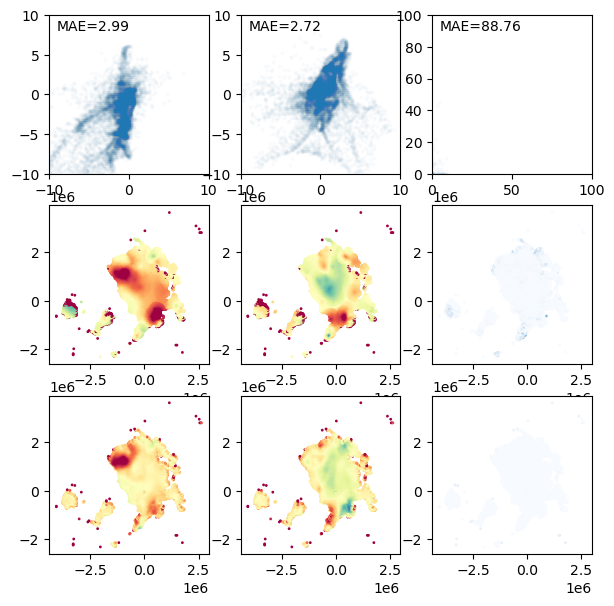

In [42]:
# Cell type visualization -------------------------------
pred = model.predict(input0)

fig, ax = plt.subplots(3, 3, figsize = (7,7))

vmax = [10, 10, 100]
vmin = [-10, -10, 0]
scaling = [50, 50, 100]
offset = [-0.5, -0.5, 0]
cm = ['Spectral', 'Spectral', 'Blues']

for k in range(0, len(ax)):
    obs = (output0[:, 1, 1, k] + offset[k])*scaling[k]
    prd = (pred[:, 1, 1, k] + offset[k])*scaling[k]
    ax[0, k].scatter(prd, obs,  s = 3, alpha = 0.02)
    ax[0, k].text(vmin[k] + (vmax[k]-vmin[k])*0.05, vmax[k] - (vmax[k]-vmin[k])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
    ax[0, k].set_xlim(vmin[k], vmax[k])
    ax[0, k].set_ylim(vmin[k], vmax[k])
    # ax[0, k].scatter(, conv_output[:, 1, 1, k], s = 2, alpha = 0.01)
    
    ax[1, k].scatter(xx, yy, c=obs, s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    ax[2, k].scatter(xx, yy, c=prd, s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

In [65]:
with open('../data/train_cell_5.pkl', 'rb') as file:
    xx, yy, train_input, train_output = pickle.load(file)
    
with open('../data/test_cell_1.pkl', 'rb') as file:
    xx, yy, test_input, test_output = pickle.load(file)

    
## Normal CNN (without physical loss)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='linear', input_shape=np.shape(train_input)[1:]))
# model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='linear'))
# model.add(layers.Conv2D(16, (3, 3), padding = "same", activation='linear'))
# model.add(layers.Conv2D(8, (3, 3), padding = "same", activation='linear'))
model.add(layers.Conv2D(3, (3, 3), padding = "same", activation='linear'))

# model = models.Sequential([
#     tf.keras.layers.Flatten(input_shape=np.shape(train_input)[1:]),
#     tf.keras.layers.Dense(54, activation='relu'),
#     tf.keras.layers.Dense(3)
# ])
# model.add(layers.Dense(32, activation='tanh'))
# model.add(layers.Dense(32, activation='tanh'))
# model.add(layers.Dense(3, activation='tanh'))
model.summary()

# tf.keras.Model(inputs, outputs, name="U-Net")
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                    loss="sparse_categorical_crossentropy",
#                    metrics="accuracy")

model.compile(optimizer='adam', loss=custom_loss())
model.fit(train_input, train_output, epochs=5, verbose = 1)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 3, 3, 32)          1760      
                                                                 
 conv2d_19 (Conv2D)          (None, 3, 3, 3)           867       
                                                                 
Total params: 2,627
Trainable params: 2,627
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2917/2917 [==============================] - 5s 1ms/step - loss: 0.0459
Epoch 2/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0391
Epoch 3/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0379
Epoch 4/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0371
Epoch 5/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0365


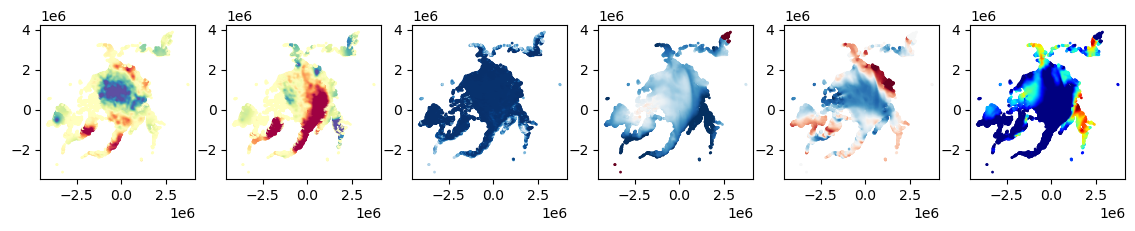

In [66]:
vmax = [10, 10, 100, 10, 10, 0.5]
vmin = [-10, -10, 0, -10, -10, 0]
scaling = [30, 30, 100, 30, 30, 1]
cm = ['Spectral', 'Spectral', 'Blues', 'RdBu', 'RdBu', 'jet']

fig, ax = plt.subplots(1, 6, figsize = (14,2))
for k in range(0, len(ax)):
    ax[k].scatter(xx, yy, c=test_input[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    # ax[2, k].scatter(xx, yy, c=test_output[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

561/561 [==============================] - 0s 706us/step


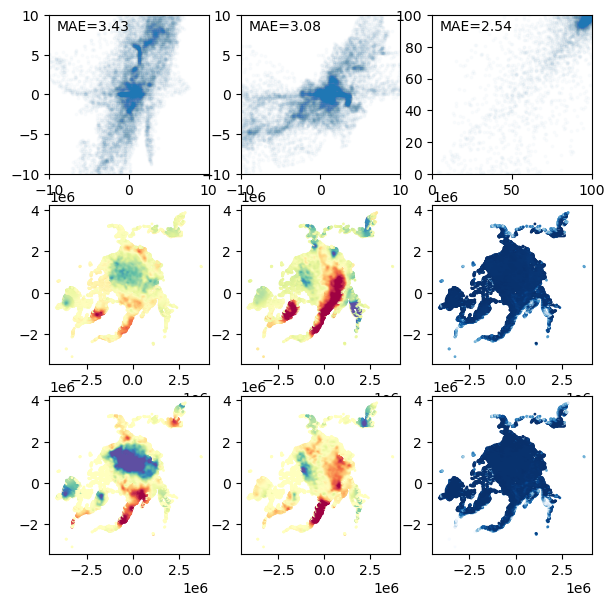

In [67]:
# Cell type visualization -------------------------------
pred = model.predict(test_input)

fig, ax = plt.subplots(3, 3, figsize = (7,7))

vmax = [10, 10, 100]
vmin = [-10, -10, 0]
scaling = [30, 30, 100]
cm = ['Spectral', 'Spectral', 'Blues']

for k in range(0, len(ax)):
    obs = test_output[:, 1, 1, k]*scaling[k]
    prd = pred[:, 1, 1, k]*scaling[k]
    ax[0, k].scatter(prd, obs,  s = 3, alpha = 0.02)
    ax[0, k].text(vmin[k] + (vmax[k]-vmin[k])*0.05, vmax[k] - (vmax[k]-vmin[k])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
    ax[0, k].set_xlim(vmin[k], vmax[k])
    ax[0, k].set_ylim(vmin[k], vmax[k])
    # ax[0, k].scatter(, conv_output[:, 1, 1, k], s = 2, alpha = 0.01)
    
    ax[1, k].scatter(xx, yy, c=pred[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    ax[2, k].scatter(xx, yy, c=test_output[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='linear', input_shape=np.shape(train_input)[1:]))
# model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='linear'))
# model.add(layers.Conv2D(16, (3, 3), padding = "same", activation='linear'))
# model.add(layers.Conv2D(8, (3, 3), padding = "same", activation='linear'))
model.add(layers.Conv2D(3, (3, 3), padding = "same", activation='linear'))

# model = models.Sequential([
#     tf.keras.layers.Flatten(input_shape=np.shape(train_input)[1:]),
#     tf.keras.layers.Dense(54, activation='relu'),
#     tf.keras.layers.Dense(3)
# ])
# model.add(layers.Dense(32, activation='tanh'))
# model.add(layers.Dense(32, activation='tanh'))
# model.add(layers.Dense(3, activation='tanh'))
model.summary()

# tf.keras.Model(inputs, outputs, name="U-Net")
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                    loss="sparse_categorical_crossentropy",
#                    metrics="accuracy")

model.compile(optimizer='adam', loss=physics_loss())
model.fit(train_input, train_output, epochs=5, verbose = 1)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 3, 3, 32)          1760      
                                                                 
 conv2d_23 (Conv2D)          (None, 3, 3, 3)           867       
                                                                 
Total params: 2,627
Trainable params: 2,627
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2917/2917 [==============================] - 5s 1ms/step - loss: 0.0798
Epoch 2/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0589
Epoch 3/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0554
Epoch 4/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0532
Epoch 5/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0535


561/561 [==============================] - 0s 729us/step


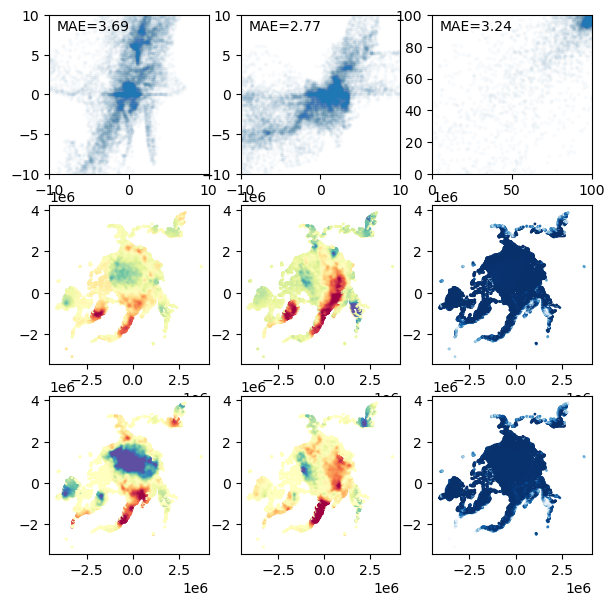

In [ ]:
# Cell type visualization -------------------------------
pred = model.predict(test_input)

fig, ax = plt.subplots(3, 3, figsize = (7,7))

vmax = [10., 10., 100.]
vmin = [-10., -10., 0.]
scaling = [30., 30., 100.]
cm = ['Spectral', 'Spectral', 'Blues']

for k in range(0, len(ax)):
    obs = test_output[:, 1, 1, k]*scaling[k]
    prd = pred[:, 1, 1, k]*scaling[k]
    ax[0, k].scatter(prd, obs,  s = 3, alpha = 0.02)
    ax[0, k].text(vmin[k] + (vmax[k]-vmin[k])*0.05, vmax[k] - (vmax[k]-vmin[k])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
    ax[0, k].set_xlim(vmin[k], vmax[k])
    ax[0, k].set_ylim(vmin[k], vmax[k])
    # ax[0, k].scatter(, conv_output[:, 1, 1, k], s = 2, alpha = 0.01)
    
    ax[1, k].scatter(xx, yy, c=pred[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    ax[2, k].scatter(xx, yy, c=test_output[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

In [26]:
np.shape(pred)

(1, 361, 361, 3)

In [32]:
pred[0, :, :, k]*scaling[k]

array([[ 6.9656024 ,  0.81510264,  1.454713  , ...,  1.454713  ,
         0.13878901, -0.8975933 ],
       [16.955044  ,  5.300949  ,  9.236865  , ...,  9.236865  ,
         9.647277  ,  0.5513682 ],
       [13.532174  ,  0.38569352,  4.4981546 , ...,  4.4981546 ,
         7.064226  , -1.7305121 ],
       ...,
       [13.532174  ,  0.38569352,  4.4981546 , ...,  4.4981546 ,
         7.064226  , -1.7305121 ],
       [22.11013   , 12.781179  , 17.415964  , ..., 17.415964  ,
        19.915138  ,  5.338277  ],
       [13.133991  ,  8.865224  , 11.339009  , ..., 11.339009  ,
        17.4142    ,  1.0690014 ]], dtype=float32)

### Normal neural network (table type)

In [ ]:
### INPUT AS A 3x3 CELL

## Read sea ice movement
try:
    nc.close()
except:
    pass

year = 2021
first = True

# ERA5 yearly data
if 'ds' not in locals():
    ds = retrieve_ERA5(year)

n_samples = np.arange(0,365,50)
xx, yy, train_input, train_output = make_dataset(year, n_samples, ds, datatype = "table")

n_samples = np.arange(60,61)
xx, yy, test_input, test_output = make_dataset(year, n_samples, ds, datatype = "table")
        
print("Complete creating input data")

In [154]:
n_samples = np.arange(60,61)
xx, yy, test_input, test_output = make_dataset(year, n_samples, ds, datatype = "table")

1it [00:26, 26.53s/it]


In [77]:
class custom_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        
        err_sum = tf.sqrt(tf.reduce_mean((obs - prd)**2))
#         err_u = (obs-prd[:, :, :, 0])**2
#         err_v = (obs[:, :, :, 1]-prd[:, :, :, 1])**2
#         err_sic = tf.abs(obs[:, :, :, 2]-prd[:, :, :, 2])
        
#         err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic))
        return err_sum
    
class physics_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        
        # Physical loss term
        u = prd[:, 0]
        v = prd[:, 1]
        
        # Divergence of sea ice drift
        div = (u[1,2]-u[1,0]) + (v[2,1]-v[0,1])
        # div = mpcalc.divergence(u, v, dx = 25 * units('km'), dy = 25 * units('km'))
        div_mean = tf.reduce_mean(div)
        div_std = tf.math.reduce_std(div)
        
        # SIC change
        d_sic = tf.reduce_mean(prd[:, 2] - obs[:, 2])
        err_phy = tf.maximum(tf.cast(tf.abs(div_mean)-div_std > 0, tf.float32) * div_mean/tf.abs(div_mean) * d_sic, 0)        

        ## Data loss term
        err_u = (obs[:, 0]-prd[:, 0])**2
        err_v = (obs[:, 1]-prd[:, 1])**2
        err_sic = tf.abs(obs[:, 2]-prd[:, 2])
        
        w = tf.constant(2.0)
        
        err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic)) + w*err_phy
        return err_sum

with open('../data/train_table_5.pkl', 'rb') as file:
    xx, yy, train_input, train_output = pickle.load(file)
    
with open('../data/test_table_1.pkl', 'rb') as file:
    xx, yy, test_input, test_output = pickle.load(file)
    

model = models.Sequential([
    tf.keras.layers.Flatten(input_shape=np.shape(train_input)[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(27)
])

model.summary()

# tf.keras.Model(inputs, outputs, name="U-Net")
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                    loss="sparse_categorical_crossentropy",
#                    metrics="accuracy")

model.compile(optimizer='adam', loss=custom_loss())
model.fit(train_input, train_output, epochs=10, verbose = 1)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 54)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               7040      
                                                                 
 dense_5 (Dense)             (None, 27)                3483      
                                                                 
Total params: 10,523
Trainable params: 10,523
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2917/2917 [==============================] - 3s 786us/step - loss: 0.1283
Epoch 2/10
2917/2917 [==============================] - 2s 729us/step - loss: 0.1172
Epoch 3/10
2917/2917 [==============================] - 2s 749us/step - loss: 0.1135
Epoch 4/10
2917/2917 [==============================] - 2s

561/561 [==============================] - 0s 600us/step


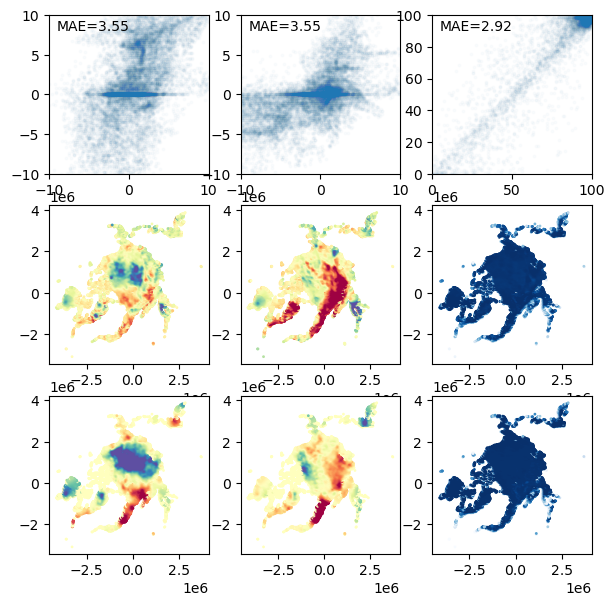

In [75]:
pred = model.predict(test_input)

fig, ax = plt.subplots(3, 3, figsize = (7,7))

vmax = [10, 10, 100]
vmin = [-10, -10, 0]
scaling = [30, 30, 100]
cm = ['Spectral', 'Spectral', 'Blues']

for k in range(0, len(ax)):
    
    obs = test_output[:, k]*scaling[k]
    prd = pred[:, k]*scaling[k]
    
    ax[0, k].text(vmin[k] + (vmax[k]-vmin[k])*0.05, vmax[k] - (vmax[k]-vmin[k])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
    ax[0, k].set_xlim(vmin[k], vmax[k])
    ax[0, k].set_ylim(vmin[k], vmax[k])
    
    ax[0, k].scatter(pred[:, k]*scaling[k], test_output[:, k]*scaling[k], s = 3, alpha = 0.02)
    # ax[0, k].scatter(, conv_output[:, 1, 1, k], s = 2, alpha = 0.01)
    
    ax[1, k].scatter(xx, yy, c=pred[:, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    ax[2, k].scatter(xx, yy, c=test_output[:, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

In [ ]:
model = models.Sequential([
    tf.keras.layers.Flatten(input_shape=np.shape(train_input)[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(27)
])

model.summary()

# tf.keras.Model(inputs, outputs, name="U-Net")
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                    loss="sparse_categorical_crossentropy",
#                    metrics="accuracy")

model.compile(optimizer='adam', loss=physics_loss())
model.fit(train_input, train_output, epochs=10, verbose = 1)

### CNN for the entire image

(320, 320, 6)


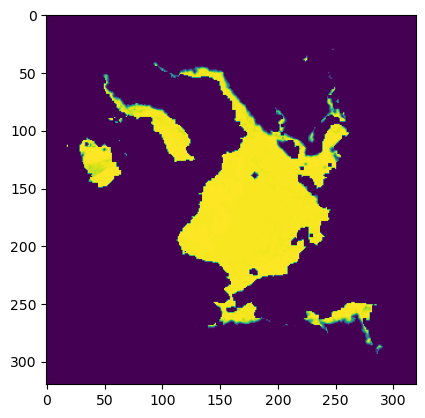

In [23]:
a = train_input[100][41:, :-41, :] #np.random.rand(30, 320, 320, 3);
print(np.shape(a))
plt.imshow(a[:, :, 2])

#### CNN

In [3]:
files = glob.glob('../data/train_entire_20*.pkl')
print(files)

first = True
for f in files:
    with open(f, 'rb') as file:
        xx, yy, input0, output0 = pickle.load(file)
        output0[:, :, :, 2] = output0[:, :, :, 2] - input0[:, :, :, 2]
    if first:
        train_input = input0
        train_output = output0
        first = False
    else:
        train_input = np.concatenate((train_input, input0))
        train_output = np.concatenate((train_output, output0))
    
with open('../data/train_entire_202103.pkl', 'rb') as file:
    xx, yy, test_input, test_output = pickle.load(file)

['../data\\train_entire_202101.pkl', '../data\\train_entire_202102.pkl', '../data\\train_entire_202103.pkl', '../data\\train_entire_202104.pkl', '../data\\train_entire_202105.pkl', '../data\\train_entire_202106.pkl', '../data\\train_entire_202107.pkl', '../data\\train_entire_202108.pkl', '../data\\train_entire_202109.pkl', '../data\\train_entire_202110.pkl', '../data\\train_entire_202111.pkl', '../data\\train_entire_202112.pkl']


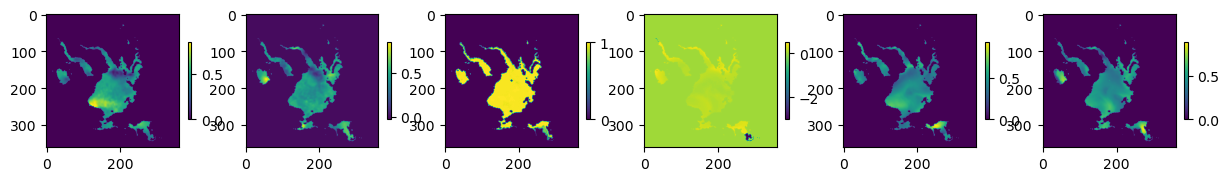

In [8]:
ind = 80
fig, ax = plt.subplots(1, 6, figsize = (15,2))
for k in range(0, len(ax)):
    p = ax[k].imshow(train_input[ind, :, :, k])
    fig.colorbar(p, ax=ax[k], shrink = 0.5)
    # ax[2, k].scatter(xx, yy, c=test_output[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

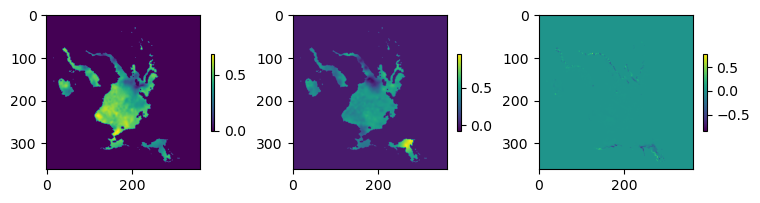

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (9,2))
for k in range(0, len(ax)):
    p = ax[k].imshow(train_output[ind, :, :, k])
    fig.colorbar(p, ax=ax[k], shrink = 0.5)
    # ax[2, k].scatter(xx, yy, c=test_output[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

In [11]:
class custom_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        
        
        err_u = (obs[:, :, :, 0]-prd[:, :, :, 0])**2
        err_v = (obs[:, :, :, 1]-prd[:, :, :, 1])**2
        err_sic = (obs[:, :, :, 2]-prd[:, :, :, 2])**2
        
        obs_vel = obs[:, :, :, 0]**2 + obs[:, :, :, 1]**2
        prd_vel = prd[:, :, :, 0]**2 + prd[:, :, :, 1]**2
        err_vel = tf.abs(obs_vel-prd_vel)
        
        err_sum = tf.sqrt(tf.reduce_mean((err_u + err_v + err_vel) + err_sic))
        # err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic))
        return err_sum
    
class physics_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        
        err_u = (obs[:, :, :, 0]-prd[:, :, :, 0])**2
        err_v = (obs[:, :, :, 1]-prd[:, :, :, 1])**2
        err_sic = (obs[:, :, :, 2]-prd[:, :, :, 2])**2
        
        obs_vel = obs[:, :, :, 0]**2 + obs[:, :, :, 1]**2
        prd_vel = prd[:, :, :, 0]**2 + prd[:, :, :, 1]**2
        err_vel = tf.abs(obs_vel-prd_vel)
        err_sum = tf.sqrt(tf.reduce_mean((err_u + err_v + err_vel) + err_sic))
        
        # Physical loss term
        u = prd[:, :, :, 0]
        v = prd[:, :, :, 1]
        d_sic = prd[:, 1:-1, 1:-1, 2]
        
        dy = prd[:, 2:, 1:-1, 0] - prd[:, :-2, 1:-1, 0]
        dx = prd[:, 1:-1, 2:, 0] - prd[:, 1:-1, :-2, 0]
        div = dx + dy
        div_std = tf.math.reduce_std(div) / 2
        
        # SIC change
        d_sic = tf.reduce_mean(prd[:, 2] - obs[:, 2])
        err_phy = tf.reduce_mean(tf.where(div*d_sic > 0, div * d_sic, 0))
        # err_phy = tf.maximum(tf.cast(tf.abs(div_mean)-div_std > 0, tf.float32) * div_mean/tf.abs(div_mean) * d_sic, 0)        
        
        w = tf.constant(2.0)
        
        err_sum += w*err_phy
        return err_sum

## Normal CNN (without physical loss)
model = models.Sequential()

n_layer = 6
n_filter = 32

model.add(layers.Conv2D(n_filter, (3, 3), padding = "same", activation='relu', input_shape=np.shape(train_input)[1:]))

for i in range(0, n_layer-1):
    model.add(layers.Conv2D(n_filter, (3, 3), padding = "same", activation='relu'))

model.add(layers.Conv2D(3, (3, 3), padding = "same", activation='relu'))
model.compile(optimizer='adam', loss=physics_loss())
model.summary()

history = model.fit(train_input, train_output, epochs=10, verbose = 1)
model.save("../model/conv2d_{0}_{1}_phy".format(n_layer, n_filter))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 361, 361, 32)      1760      
                                                                 
 conv2d_8 (Conv2D)           (None, 361, 361, 32)      9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 361, 361, 32)      9248      
                                                                 
 conv2d_10 (Conv2D)          (None, 361, 361, 32)      9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 361, 361, 32)      9248      
                                                                 
 conv2d_12 (Conv2D)          (None, 361, 361, 32)      9248      
                                                                 
 conv2d_13 (Conv2D)          (None, 361, 361, 3)      

INFO:tensorflow:Assets written to: ../model/conv2d_6_32_phy\assets


INFO:tensorflow:Assets written to: ../model/conv2d_6_32_phy\assets


1/1 [==============================] - 1s 1s/step


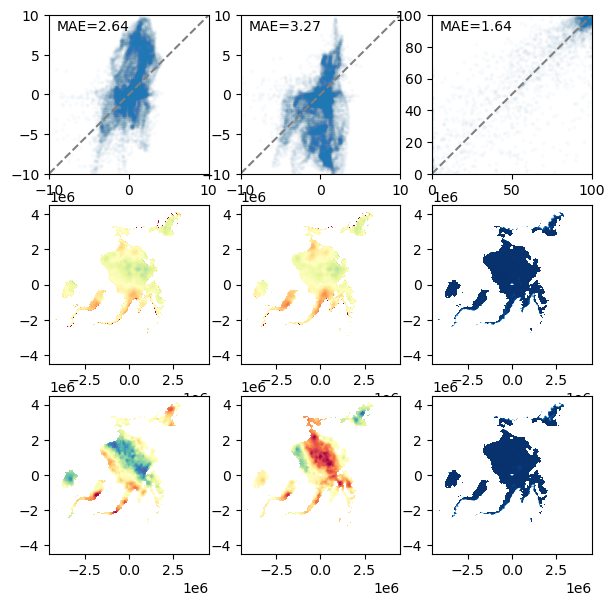

In [19]:
# Cell type visualization -------------------------------
ind = 5

pred = model.predict(test_input)
sic = test_output[ind, :, :, 2]

fig, ax = plt.subplots(3, 3, figsize = (7,7))

vmax = [10, 10, 100]
vmin = [-10, -10, 0]
scaling = [30, 30, 100]
offset = [-0.5, -0.5, 0]
cm = ['Spectral', 'Spectral', 'Blues']

for k in range(0, len(ax)):
    
    obs = (test_output[ind, :, :, k] + offset[k])*scaling[k]
    
    if k == 2:        
        prd = (pred[ind, :, :, k] + test_input[ind, :, :, k] + offset[k])*scaling[k]
    else:
        prd = (pred[ind, :, :, k] + offset[k])*scaling[k]
    
    prd[sic == 0] = np.nan
    obs[sic == 0] = np.nan
    
    ax[0, k].scatter(prd, obs,  s = 3, alpha = 0.02)
    ax[0, k].text(vmin[k] + (vmax[k]-vmin[k])*0.05, vmax[k] - (vmax[k]-vmin[k])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
    ax[0, k].set_xlim(vmin[k], vmax[k])
    ax[0, k].set_ylim(vmin[k], vmax[k])
    ax[0, k].plot([vmin[k], vmax[k]], [vmin[k], vmax[k]], ls = "--", color = "gray")
    # ax[0, k].scatter(, conv_output[:, 1, 1, k], s = 2, alpha = 0.01)
    
    ax[1, k].pcolormesh(xx, yy, prd, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    ax[2, k].pcolormesh(xx, yy, obs, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

In [ ]:
sic = lstm_output[ind, :, :, 2]

fig, ax = plt.subplots(3, 3, figsize = (7,7))

vmax = [10, 10, 100]
vmin = [-10, -10, 0]
scaling = [30, 30, 100]
cm = ['Spectral', 'Spectral', 'Blues']

for k in range(0, len(ax)):
    obs = test_output[ind, :, :, k]*scaling[k]
    prd = pred[ind, :, :, k]*scaling[k]
    
    prd[sic == 0] = np.nan
    obs[sic == 0] = np.nan
    
    ax[0, k].scatter(prd, obs,  s = 3, alpha = 0.02)
    ax[0, k].text(vmin[k] + (vmax[k]-vmin[k])*0.05, vmax[k] - (vmax[k]-vmin[k])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
    ax[0, k].set_xlim(vmin[k], vmax[k])
    ax[0, k].set_ylim(vmin[k], vmax[k])
    ax[0, k].plot([vmin[k], vmax[k]], [vmin[k], vmax[k]], ls = "--", color = "gray")
    # ax[0, k].scatter(, conv_output[:, 1, 1, k], s = 2, alpha = 0.01)
    
    ax[1, k].pcolormesh(xx, yy, prd, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    ax[2, k].pcolormesh(xx, yy, obs, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

#### U-net

In [203]:
class custom_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        err_u = (obs[:, :, :, 0]-prd[:, :, :, 0])**2
        err_v = (obs[:, :, :, 1]-prd[:, :, :, 1])**2
        err_sic = tf.abs(obs[:, :, :, 2]-prd[:, :, :, 2])
        
        err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic))
        return err_sum
    
class physics_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        
        # Physical loss term
        u = prd[:, :, :, 0]
        v = prd[:, :, :, 1]
        
        # Divergence of sea ice drift
        div = (u[1,2]-u[1,0]) + (v[2,1]-v[0,1])
        # div = mpcalc.divergence(u, v, dx = 25 * units('km'), dy = 25 * units('km'))
        div_mean = tf.reduce_mean(div)
        div_std = tf.math.reduce_std(div)
        
        # SIC change
        d_sic = tf.reduce_mean(prd[:, :, :, 2] - obs[:, :, :, 2])
        err_phy = tf.maximum(tf.cast(tf.abs(div_mean)-div_std > 0, tf.float32) * div_mean/tf.abs(div_mean) * d_sic, 0)        

        ## Data loss term
        err_u = (obs[:, :, :, 0]-prd[:, :, :, 0])**2
        err_v = (obs[:, :, :, 1]-prd[:, :, :, 1])**2
        err_sic = tf.abs(obs[:, :, :, 2]-prd[:, :, :, 2])
        
        w = tf.constant(2.0)
        
        err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic)) + w*err_phy
        return err_sum

conv_input = train_input[:, 41:, :-41, :]
conv_output = train_output[:, 41:, :-41, :]

inputs = tf.keras.layers.Input(np.shape(conv_input[0][:, :, :]))
conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
# drop4 = tf.keras.layers.Dropout(0.5)(conv4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)


conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
# drop5 = tf.keras.layers.Dropout(0.5)(conv5)

up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(
    tf.keras.layers.UpSampling2D(size = (2,2))(conv5))
merge6 = tf.keras.layers.concatenate([conv4,up6], axis = 3)
conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(
    tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(
    tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(
    tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = tf.keras.layers.Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
# conv10 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)


model = tf.keras.Model(inputs = inputs, outputs = conv9)
# model.summary()

model.compile(optimizer = 'adam', loss = custom_loss())
history = model.fit(conv_input, conv_output, epochs=5, verbose = 1)

Epoch 1/5
12/12 [==============================] - 1019s 85s/step - loss: 5.4772
Epoch 2/5


KeyboardInterrupt: 

In [150]:
np.shape(conv_input[0])

(320, 320, 6)

1/1 [==============================] - 13s 13s/step


ValueError: operands could not be broadcast together with shapes (17925,) (29,320,3) 

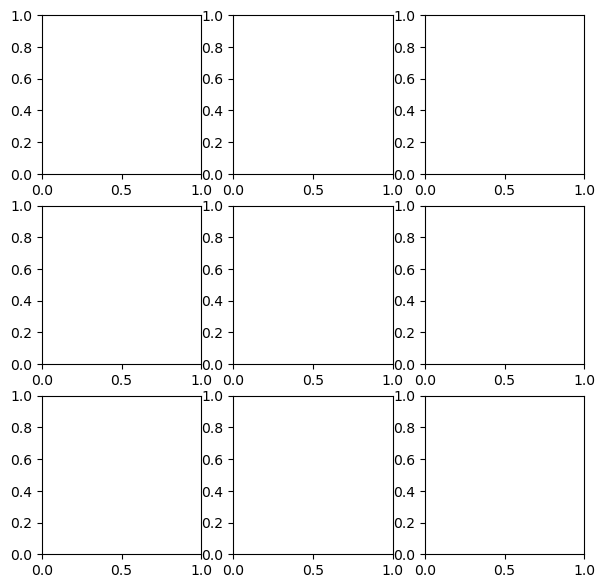

In [152]:
pred = model.predict(conv_input)

fig, ax = plt.subplots(3, 3, figsize = (7,7))

vmax = [10, 10, 100]
vmin = [-10, -10, 0]
scaling = [30, 30, 100]
cm = ['Spectral', 'Spectral', 'Blues']

for k in range(0, len(ax)):
    
    obs = test_output[:, k]*scaling[k]
    prd = pred[:, k]*scaling[k]
    
    ax[0, k].text(vmin[k] + (vmax[k]-vmin[k])*0.05, vmax[k] - (vmax[k]-vmin[k])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
    ax[0, k].set_xlim(vmin[k], vmax[k])
    ax[0, k].set_ylim(vmin[k], vmax[k])
    
    ax[0, k].scatter(pred[:, k]*scaling[k], test_output[:, k]*scaling[k], s = 3, alpha = 0.02)
    # ax[0, k].scatter(, conv_output[:, 1, 1, k], s = 2, alpha = 0.01)
    
    ax[1, k].scatter(xx, yy, c=pred[:, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    ax[2, k].scatter(xx, yy, c=test_output[:, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

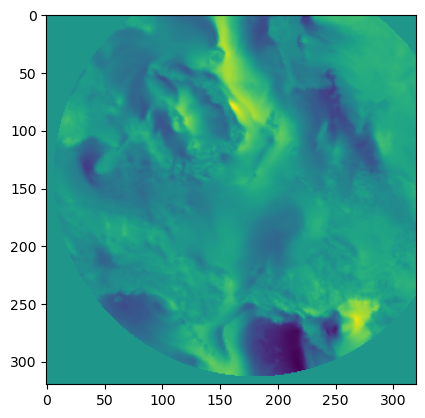

In [166]:
plt.imshow(conv_input[0, :, :, 5])

In [ ]:
class custom_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        err_u = (obs[:, :, :, 0]-prd[:, :, :, 0])**2
        err_v = (obs[:, :, :, 1]-prd[:, :, :, 1])**2
        err_sic = tf.abs(obs[:, :, :, 2]-prd[:, :, :, 2])
        
        err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic))
        return err_sum
    
class physics_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        
        # Physical loss term
        u = prd[:, :, :, 0]
        v = prd[:, :, :, 1]
        
        # Divergence of sea ice drift
        div = (u[1,2]-u[1,0]) + (v[2,1]-v[0,1])
        # div = mpcalc.divergence(u, v, dx = 25 * units('km'), dy = 25 * units('km'))
        div_mean = tf.reduce_mean(div)
        div_std = tf.math.reduce_std(div)
        
        # SIC change
        d_sic = tf.reduce_mean(prd[:, :, :, 2] - obs[:, :, :, 2])
        err_phy = tf.maximum(tf.cast(tf.abs(div_mean)-div_std > 0, tf.float32) * div_mean/tf.abs(div_mean) * d_sic, 0)        

        ## Data loss term
        err_u = (obs[:, :, :, 0]-prd[:, :, :, 0])**2
        err_v = (obs[:, :, :, 1]-prd[:, :, :, 1])**2
        err_sic = tf.abs(obs[:, :, :, 2]-prd[:, :, :, 2])
        
        w = tf.constant(2.0)
        
        err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic)) + w*err_phy
        return err_sum
    
    def divergence(u, v):
        
    
def MAE(obs, prd):
    return np.mean(abs(obs-prd))

with open('../data/train_cell_5.pkl', 'rb') as file:
    xx, yy, train_input, train_output = pickle.load(file)
    
with open('../data/test_cell_1.pkl', 'rb') as file:
    xx, yy, test_input, test_output = pickle.load(file)

    
## Normal CNN (without physical loss)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='linear', input_shape=np.shape(train_input)[1:]))
model.add(layers.Conv2D(3, (3, 3), padding = "same", activation='linear'))

# model = models.Sequential([
#     tf.keras.layers.Flatten(input_shape=np.shape(train_input)[1:]),
#     tf.keras.layers.Dense(54, activation='relu'),
#     tf.keras.layers.Dense(3)
# ])
# model.add(layers.Dense(32, activation='tanh'))
# model.add(layers.Dense(32, activation='tanh'))
# model.add(layers.Dense(3, activation='tanh'))
model.summary()

# tf.keras.Model(inputs, outputs, name="U-Net")
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                    loss="sparse_categorical_crossentropy",
#                    metrics="accuracy")

model.compile(optimizer='adam', loss=custom_loss())
model.fit(train_input, train_output, epochs=5, verbose = 1)

In [108]:
class Custom_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        err_sic = 0 #tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        return err_u + err_v + err_sic
        
        # return 
    
    
def weighted_loss(obs, prd):
    err_u = tf.abs(obs[:, 1, 1, 0]-prd[:, 1, 1, 0]) / tf.reduce_mean(obs[:, 1, 1, 0]-prd[:, 1, 1, 0])
    err_v = tf.abs(obs[:, 1, 1, 1]-prd[:, 1, 1, 1]) / tf.reduce_mean(obs[:, 1, 1, 1]-prd[:, 1, 1, 1])
    err_sic = tf.abs(obs[:, 1, 1, 2]-prd[:, 1, 1, 2]) / tf.reduce_mean(obs[:, 1, 1, 2]-prd[:, 1, 1, 2])
    return err_sic

In [32]:
np.shape(pred)

(17677, 3, 3, 3)

In [320]:
def make_loss_functions(self):
        
    def radar_data_loss(obs, pred):
        h_pred = pred[:,0] * self.dataset.h_scale
        h = obs[:,0]

        finite_labels = tf.math.is_finite(h)

        if self.radar_data_norm_type == 1:
            data_loss = tf.reduce_mean(tf.abs(tf.boolean_mask(h, finite_labels) - tf.boolean_mask(h_pred, finite_labels)))
        else:
            data_loss = tf.reduce_mean(tf.square(tf.boolean_mask(h, finite_labels) - tf.boolean_mask(h_pred, finite_labels)))
        data_loss = tf.where(tf.math.is_nan(data_loss), tf.zeros_like(data_loss), data_loss)

        return data_loss
    self.radar_data_loss = radar_data_loss

    def velocity_data_loss(obs, pred):
        vx_pred = pred[:,1] * self.dataset.v_scale
        vy_pred = pred[:,2] * self.dataset.v_scale
        vx = obs[:,1]
        vy = obs[:,2]

        finite_labels = tf.math.is_finite(vx)

        vx_finite = tf.boolean_mask(vx, finite_labels)
        vy_finite = tf.boolean_mask(vy, finite_labels)
        vx_pred_finite = tf.boolean_mask(vx_pred, finite_labels)
        vy_pred_finite = tf.boolean_mask(vy_pred, finite_labels)

        vx_error = tf_error_outside_bounds(vx_pred_finite, vx_finite, self.velocity_error_upper, self.velocity_error_allowed)
        vy_error = tf_error_outside_bounds(vy_pred_finite, vy_finite, self.velocity_error_upper, self.velocity_error_allowed)

        velocity_data_loss = (tf.reduce_mean(vx_error) + tf.reduce_mean(vy_error)) / 2

        return velocity_data_loss
    self.velocity_data_loss = velocity_data_loss

    def surface_velocity_data_loss(obs, pred):
        surf_vx_pred = pred[:,3] * self.dataset.v_scale
        surf_vy_pred = pred[:,4] * self.dataset.v_scale
        vx = obs[:,1]
        vy = obs[:,2]

        finite_labels = tf.math.is_finite(vx)

        vx_diff = tf.boolean_mask(vx, finite_labels) - tf.boolean_mask(surf_vx_pred, finite_labels)
        vy_diff = tf.boolean_mask(vy, finite_labels) - tf.boolean_mask(surf_vy_pred, finite_labels)

        surf_velocity_data_loss = (tf.reduce_mean(tf.square(vx_diff)) + tf.reduce_mean(tf.square(vy_diff))) / 2

        return surf_velocity_data_loss
    self.surface_velocity_data_loss = surface_velocity_data_loss

    # Velocity magnitude
    def velocity_mag_data_loss(obs, pred):
        vx_pred = pred[:,1] * self.dataset.v_scale
        vy_pred = pred[:,2] * self.dataset.v_scale
        vx = obs[:,1]
        vy = obs[:,2]

        finite_labels = tf.math.is_finite(vx)

        vx_finite = tf.boolean_mask(vx, finite_labels)
        vy_finite = tf.boolean_mask(vy, finite_labels)
        vx_pred_finite = tf.boolean_mask(vx_pred, finite_labels)
        vy_pred_finite = tf.boolean_mask(vy_pred, finite_labels)

        obs_mag = tf.math.sqrt(tf.square(vx_finite)+tf.square(vy_finite))
        obs_mag_safe = tf.where(tf.math.is_finite(obs_mag), obs_mag, tf.zeros_like(obs_mag))

        pred_mag = tf.math.sqrt(tf.square(vx_pred_finite)+tf.square(vy_pred_finite))
        pred_mag_safe = tf.where(tf.math.is_finite(pred_mag), pred_mag, tf.zeros_like(pred_mag))

        return tf.reduce_mean(tf_error_outside_bounds(pred_mag_safe, obs_mag_safe, self.velocity_error_upper, self.velocity_error_allowed))

    self.velocity_mag_data_loss = velocity_mag_data_loss




    def negative_thickness_loss(obs, pred):
        h = pred[:,0]
        return tf.reduce_mean(tf.square(tf.minimum(h, 0)))
    self.negative_thickness_loss = negative_thickness_loss


    def gen_loss(obs, pred, weights=self.loss_weights):
        loss = weights.get('radar_data', 1.0) * radar_data_loss(obs, pred)
        loss += weights.get('velocity_data', 1.0) * velocity_data_loss(obs, pred)
        loss += weights.get('negative_thickness', 1.0) * negative_thickness_loss(obs, pred)
        loss += weights.get('model', 1.0) * model_loss(obs, pred)
        loss += weights.get('thickness_smoothing', 1.0) * thickness_smoothing_loss(obs, pred)
        loss += weights.get('velocity_smoothing', 1.0) * velocity_smoothing_loss(obs, pred)

        loss += weights.get('velocity_mag_data', 1.0) * velocity_mag_data_loss(obs, pred)
        loss += weights.get('velocity_ang_data', 1.0) * velocity_ang_data_loss(obs, pred)

        if self.predict_surface_velocity:
            loss += weights.get('velocity_diff_smoothing', 1.0) * velocity_diff_smoothing_loss(obs, pred)
            loss += weights.get('surface_velocity_data', 1.0) * surface_velocity_data_loss(obs, pred)
        return loss
    self.gen_loss = gen_loss


    def unweighted_loss(obs, pred):
        return gen_loss(obs, pred, weights={})
    self.unweighted_loss = unweighted_loss



def compile(self):
    super(PINN, self).compile()

    self.make_loss_functions()

    gen_opt = tf.keras.optimizers.Adam(learning_rate=self.gen_learning_rate)

    metrics = [self.unweighted_loss, self.radar_data_loss, self.velocity_data_loss, self.model_loss,
                self.negative_thickness_loss, self.thickness_smoothing_loss, self.velocity_smoothing_loss,
                self.velocity_mag_data_loss, self.velocity_ang_data_loss]
    if self.predict_surface_velocity:
        metrics.append(self.velocity_diff_smoothing_loss)
        metrics.append(self.surface_velocity_data_loss)

    self.generator.compile(optimizer=gen_opt, loss=self.gen_loss, metrics=metrics)

(21, 3, 3, 6)

In [280]:
## INPUT AS A ONE PICTURE

## Read sea ice movement
try:
    nc.close()
except:
    pass

year = 2021

# ncfile = glob.glob("F:\\2022_Ross\\ERA5\\icemotion_daily_sh_25km_{0}*.nc".format(year))[0]
ncfile = "../data/Sea_ice_drift/icemotion_daily_nh_25km_{0}0101_{0}1231_v4.1.nc".format(year)
nc = netCDF4.Dataset(ncfile, 'r')
days = np.array(nc.variables['time']).astype(float)[:20]
row, col = np.shape(np.array(nc.variables['latitude']))

# ERA5 yearly data
ds = retrieve_ERA5(year)
grid_input = np.zeros([len(days), row, col, 6])
grid_output = np.zeros([len(days), row, col, 3])

for i in tqdm(range(0, len(days))):
    t1 = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[i])
    t2 = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[i]+1)
    
    ## Read ice motion data ===========================================
    sampling_size = 1
    xx, yy, lat, lon, grid_u, grid_v = get_ice_motion(ncfile, i, sampling_size)
    grid_u = np.mean(grid_u, axis = 0)
    grid_v = np.mean(grid_v, axis = 0)
    
    ## Read SIC data ==================================================
    grid_sic = get_SIC(t1) * 0.01 # Change into 0-1
    
    ## Read ERA5 data =================================================
    grid_t2m, grid_u10, grid_v10 = get_ERA5(ds, i, xx, yy)
    
    grid_input[i, :, :, 0] = grid_u / 30
    grid_input[i, :, :, 1] = grid_v / 30
    grid_input[i, :, :, 2] = grid_sic
    grid_input[i, :, :, 3] = (grid_t2m - 240)/(320 - 240) #Max temp = 320 K, Min temp = 240 K)
    grid_input[i, :, :, 4] = grid_u10 / 30
    grid_input[i, :, :, 5] = grid_v10 / 30
        
    _, _, _, _, grid_output[i, :, :, 0], grid_output[i, :, :, 1] = get_ice_motion(ncfile, i+1, sampling_size)
    grid_output[i, :, :, 2] = get_SIC(t2)   
    
nc.close()

2023-06-21 17:38:25,324 INFO Welcome to the CDS
2023-06-21 17:38:25,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-06-21 17:38:25,467 INFO Request is completed
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.31s/it]


In [15]:
model = models.Sequential()
model.add(layers.Conv2D(3, (1, 1), padding = "same", activation='relu', input_shape=np.shape(conv_input)[1:]))
model.add(layers.Conv2D(3, (1, 1), padding = "same", activation='relu'))
model.add(layers.Conv2D(3, (3, 3), padding = "same", activation='relu'))
model.summary()

# tf.keras.Model(inputs, outputs, name="U-Net")
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                    loss="sparse_categorical_crossentropy",
#                    metrics="accuracy")

model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError())
model.fit(train_input, train_output, epochs=5)

model.predict(conv_input)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 3, 3)           21        
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 3)           12        
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 3)           84        
                                                                 
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
553/553 [==============================] - 1s 913us/step - loss: 22.5706
Epoch 2/5
553/553 [==============================] - 1s 908us/step - loss: 9.6111
Epoch 3/5
553/553 [==============================] - 0s 890us/step - loss: 7.8423
Epoch 4/5
553/553 [==============================] - 0s 888us/step - loss: 

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

inputs = tf.keras.layers.Input(np.shape(grid_input[0][:-1, :-1, :]))
conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = tf.keras.layers.Dropout(0.5)(conv4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = tf.keras.layers.Dropout(0.5)(conv5)

up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
conv7 = tf.keras.layers.tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

# model = Model(input = inputs, output = conv10)

# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [199]:
def cnn(self, nb_inputs, nb_outputs):
        """
            Routine serve to build a convolutional neural network
        """

        inputs = tf.keras.layers.Input(shape=[None, None, nb_inputs])

        conv = inputs
        
        # if self.config.normalize:
        #     conv = tf.keras.layers.Normalization(axis=-1,
        #                                          mean=[0 for i in range(nb_inputs)],
        #                                          variance=self.norm_in)(conv)
        
#        initializer = tf.keras.initializers.GlorotUniform()

        if self.config.activation == "lrelu":
            activation = tf.keras.layers.LeakyReLU(alpha=0.01)
        else:
            activation = tf.keras.layers.ReLU()

        for i in range(int(self.config.nb_layers)):

            conv = tf.keras.layers.Conv2D(
                filters=self.config.nb_out_filter,
                kernel_size=(self.config.conv_ker_size, self.config.conv_ker_size),
 #               kernel_initializer = initializer,
                padding="same",
            )(conv)

            conv = activation(conv)

            conv = tf.keras.layers.Dropout(self.config.dropout_rate)(conv)

        outputs = conv

        outputs = tf.keras.layers.Conv2D(filters=nb_outputs, \
                                         kernel_size=(1, 1), \
#                                         kernel_initializer = initializer, \
                                         activation=None)(outputs)

        # if self.config.normalize:
        #     outputs = tf.keras.layers.Normalization(axis=-1,
        #                                             mean=[0 for i in range(nb_outputs)],
        #                                             variance=self.norm_out)(outputs)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

(361, 361, 6)

### CNN example codes (Tensorflow Tutorial)

In [171]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [172]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 5s 0us/step
